In [1]:
from fastai.vision.all import *

In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [3]:
path = Path('/home/user/images')

In [4]:
path.ls()

(#1000) [Path('/home/user/images/Bathygobius krefftii'),Path('/home/user/images/Oncorhynchus gorbuscha'),Path('/home/user/images/Chromis margaritifer'),Path('/home/user/images/Istigobius hoesei'),Path('/home/user/images/Abudefduf sordidus'),Path('/home/user/images/Acanthurus leucopareius'),Path('/home/user/images/Sphoeroides spengleri'),Path('/home/user/images/Orthopristis chrysoptera'),Path('/home/user/images/Etheostoma zonale'),Path('/home/user/images/Morone mississippiensis')...]

In [5]:
df_path = Path('/home/user/')

In [8]:
df = pd.read_csv(df_path/'csv/species1000-stratified.csv')

In [9]:
df

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
0,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,Lepomis gibbosus/1879321.jpg,False
1,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,Pomoxis nigromaculatus/61056925.jpg,False
2,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis miniatus,Lepomis miniatus/36578909.jpg,False
3,Cypriniformes,Cyprinidae,Leuciscinae,Scardinius,Scardinius erythrophthalmus,Scardinius erythrophthalmus/77068790.jpg,False
4,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus olivaceus,Acanthurus olivaceus/14646458.jpg,False
...,...,...,...,...,...,...,...
422172,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus coeruleus,Acanthurus coeruleus/33472582.jpg,True
422173,Perciformes,Gobiidae,Gobiinae,Amblyeleotris,Amblyeleotris steinitzi,Amblyeleotris steinitzi/3789141.jpg,True
422174,Perciformes,Percidae,Etheostomatinae,Etheostoma,Etheostoma caeruleum,Etheostoma caeruleum/40879890.jpg,True
422175,Perciformes,Kyphosidae,Microcanthinae,Tilodon,Tilodon sexfasciatus,Tilodon sexfasciatus/26825770.jpg,True


In [10]:
weights_df = pd.read_csv(df_path/'csv/species1000-weights.csv')
weights_family_df = pd.read_csv(df_path/'csv/species1000-weights-family.csv')
weights_genus_df = pd.read_csv(df_path/'csv/species1000-weights-genus.csv')
weights_order_df = pd.read_csv(df_path/'csv/species1000-weights-order.csv')

In [11]:
weights_df

,Specie,Count,Weight
0,Abramis brama,319,1.323439
1,Abudefduf abdominalis,221,1.910303
2,Abudefduf bengalensis,323,1.307050
3,Abudefduf saxatilis,1692,0.249514
4,Abudefduf septemfasciatus,149,2.833403
...,...,...,...
995,Zanclus cornutus,1966,0.214739
996,Zebrasoma desjardinii,166,2.543235
997,Zebrasoma flavescens,561,0.752544
998,Zebrasoma scopas,276,1.529627


# Non-branch

In [12]:
fishes = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=ColReader(4),
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df, bs=64)

In [11]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, TensorCategory(531)),(PILImage mode=RGB size=1024x738, TensorCategory(776)),(PILImage mode=RGB size=768x1024, TensorCategory(538)),(PILImage mode=RGB size=768x1024, TensorCategory(837)),(PILImage mode=RGB size=1024x786, TensorCategory(32)),(PILImage mode=RGB size=1024x683, TensorCategory(145)),(PILImage mode=RGB size=768x1024, TensorCategory(827)),(PILImage mode=RGB size=1024x697, TensorCategory(792)),(PILImage mode=RGB size=1024x768, TensorCategory(784)),(PILImage mode=RGB size=1024x768, TensorCategory(522))...],
 (#84436) [(PILImage mode=RGB size=576x1024, TensorCategory(826)),(PILImage mode=RGB size=512x320, TensorCategory(296)),(PILImage mode=RGB size=1024x768, TensorCategory(283)),(PILImage mode=RGB size=1024x683, TensorCategory(223)),(PILImage mode=RGB size=1024x683, TensorCategory(333)),(PILImage mode=RGB size=1024x768, TensorCategory(272)),(PILImage mode=RGB size=1024x576, TensorCategory(163)),(PILImage mode=RGB size=1024x768, Tenso

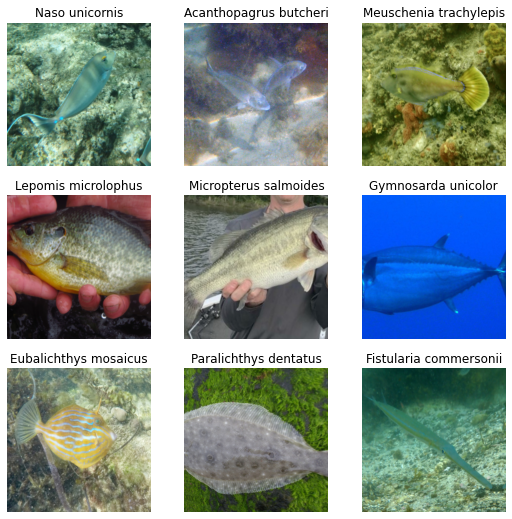

In [12]:
dls.show_batch(nrows=3, ncols=3)

In [13]:
class Resnet34CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [14]:
def custom_splitter(model):
    return [params(model.encoder),
            params(model.head)]

In [15]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [16]:
model = resnet34
body = create_body(model, cut=-2)
head = create_head(512*2,dls.c)

In [17]:
model = Resnet34CustomModel(body, head)

In [18]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()

In [19]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [20]:
learn.summary()

Resnet34CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 64 x 64 x 84 x 84    0          False     
________________________________________

In [21]:
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.449109,2.802183,0.401997,26:29


In [22]:
learn.unfreeze()
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-nobranch-fepochs1-uepochs5')

epoch,train_loss,valid_loss,accuracy,time
0,3.010569,2.348903,0.496933,26:46
1,2.850574,2.210580,0.518535,26:54
2,2.668118,2.123080,0.535151,26:53
3,2.593833,2.055493,0.545241,26:55
4,2.577320,1.992223,0.556469,26:51


Path('models/species1000-resnet34-nobranch-fepochs1-uepochs5.pth')

In [ ]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                       splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [23]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-nobranch-fepochs1-uepochs10')

epoch,train_loss,valid_loss,accuracy,time
0,2.522961,1.958896,0.562094,26:58
1,2.418562,1.908316,0.568999,27:02
2,2.382770,1.878833,0.574696,26:58
3,2.391359,1.845588,0.582477,26:53
4,2.332343,1.818241,0.588031,26:58


Path('models/species1000-resnet34-nobranch-fepochs1-uepochs10.pth')

In [24]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-nobranch-fepochs1-uepochs15')

epoch,train_loss,valid_loss,accuracy,time
0,2.232615,1.789293,0.591489,27:02
1,2.303785,1.767356,0.597695,27:00
2,2.247974,1.749336,0.599626,26:57
3,2.247029,1.714650,0.603013,27:04
4,2.190866,1.699940,0.608425,26:56


Path('models/species1000-resnet34-nobranch-fepochs1-uepochs15.pth')

In [25]:
learn.export('species1000-resnet34-nobranch-fepochs1-uepochs15')

# 1-Branch-CNN

In [13]:
model = resnet34
body = create_body(model, cut=-2)
body

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
stem = body[0:4]
stem

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [15]:
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
block1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [16]:
head = create_head(512*2,dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1000, bias=False)
)

In [17]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse1_label = o['Family']
    return [coarse1_label, fine_label]

In [18]:
class Resnet34CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.block2 = body[5]
        self.branch1 = create_head(128*2, len(set(df['Family'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        coarse1_label = self.branch1(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse1_label': coarse1_label
               }

In [19]:
model = Resnet34CustomModel(body, head)

In [20]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [21]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [22]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [23]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [24]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse1_label': TensorCategory(41)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse1_label': TensorCategory(109)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse1_label': TensorCategory(108)}),(PILImage mode=RGB size=1024x697, {'fine_label': TensorCategory(792), 'coarse1_label': TensorCategory(100)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(784), 'coarse1_label': TensorCategory(9)}),(PILImage mode=R

In [25]:
dls.vocab, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...])

In [26]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()

In [27]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label'])

In [28]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [42]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [43]:
learn.summary()

Resnet34CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 64 x 64 x 84 x 84    0          False     
________________________________________

In [44]:
learn.fit(1, 3e-3)
learn.save('species1000-resnet34-branch1-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,8.703850,7.834898,0.374437,26:45


Path('models/species1000-resnet34-branch1-fepochs1-uepochs0.pth')

In [45]:
learn.unfreeze()
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch1-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,7.698918,6.975236,0.519364,27:04
1,7.546740,6.697124,0.557061,27:17
2,7.215803,6.536081,0.579078,27:38
3,7.033795,6.384839,0.598951,26:46
4,6.884779,6.277026,0.609420,27:02


Path('models/species1000-resnet34-branch1-fepochs1-uepochs5.pth')

In [29]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [30]:
learn = continue_training('species1000-resnet34-branch1-fepochs1-uepochs5')

In [31]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch1-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,6.783722,6.216621,0.619534,28:46
1,6.591565,6.136740,0.630146,28:49
2,6.648280,6.061100,0.638969,28:53
3,6.401560,6.003661,0.650919,28:37
4,6.377171,5.953341,0.654223,27:13


Path('models/species1000-resnet34-branch1-fepochs1-uepochs10.pth')

In [32]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch1-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,6.313942,5.934981,0.655787,27:21
1,6.219078,5.892819,0.661199,27:28
2,6.148957,5.848469,0.671053,27:30
3,6.116019,5.824296,0.670970,27:16
4,6.034589,5.794313,0.675683,27:13


Path('models/species1000-resnet34-branch1-fepochs1-uepochs15.pth')

In [33]:
learn.export('species1000-resnet34-branch1-fepochs1-uepochs15')

# 2-Branch-CNN

In [34]:
model = resnet34
body = create_body(model, cut=-2)
stem = body[0:4]
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
head = create_head(512*2,dls.c)

In [35]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse2_label = o['Family']
    coarse1_label = o['Order']
    return [coarse1_label, coarse2_label, fine_label]

In [36]:
class Resnet34CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.branch1 = create_head(64*2, len(set(df['Order'])))
        self.block2 = body[5]
        self.branch2 = create_head(128*2, len(set(df['Family'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        coarse1_label = self.branch1(x)
        x = self.block2(x)
        coarse2_label = self.branch2(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse2_label': coarse2_label,
                'coarse1_label': coarse1_label
               }

In [37]:
model = Resnet34CustomModel(body, head)

In [38]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)
        self.vocab_coarse2 = None if vocab_coarse2 is None else CategoryMap(vocab_coarse2, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[2] for d in dsets]
        coarse2_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse2 is None and dsets is not None: self.vocab_coarse2 = CategoryMap(coarse2_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[2]]),
                                  'coarse2_label': TensorCategory(self.vocab_coarse2.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [39]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [40]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [41]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [42]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse2_label': TensorCategory(41), 'coarse1_label': TensorCategory(10)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse2_label': TensorCategory(0), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse2_label': TensorCategory(109), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse2_label': TensorCategory(108), 'coarse1_la

In [43]:
dls.vocab, dls.vocab_coarse2, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...],
 (#29) ['Acipenseriformes','Amiiformes','Anguilliformes','Atheriniformes','Aulopiformes','Batrachoidiformes','Beloniformes','Beryciformes','Characiformes','Clupeiformes'...])

In [44]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_order = tensor([float(weights_order_df[weights_order_df['Order']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse2]).cuda()

In [45]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_order)(out['coarse1_label'], targ['coarse1_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse2_label'], targ['coarse2_label'])

In [46]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [47]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [48]:
learn.summary()

Resnet34CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 64 x 64 x 84 x 84    0          False     
________________________________________

In [49]:
learn.fit(1, 3e-3)
learn.save('species1000-resnet34-branch2-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,12.395494,11.220432,0.381176,27:11


Path('models/species1000-resnet34-branch2-fepochs1-uepochs0.pth')

In [50]:
learn.unfreeze()
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch2-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,11.326385,10.361807,0.507248,27:24
1,11.003396,10.057730,0.543986,27:25
2,10.622349,9.860905,0.569402,27:23
3,10.619615,9.715158,0.583507,27:30
4,10.419349,9.613215,0.593941,29:42


Path('models/species1000-resnet34-branch2-fepochs1-uepochs5.pth')

In [55]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [51]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch2-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,10.155854,9.503171,0.611552,28:01
1,10.147539,9.410563,0.622353,27:40
2,10.086348,9.344399,0.627268,29:30
3,9.962287,9.278068,0.637951,27:48
4,9.879227,9.215546,0.642771,27:38


Path('models/species1000-resnet34-branch2-fepochs1-uepochs10.pth')

In [56]:
learn = continue_training('species1000-resnet34-branch2-fepochs1-uepochs10')

In [57]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet34-branch2-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,9.863610,9.187529,0.647994,27:24
1,9.769130,9.160567,0.648467,27:27
2,9.586393,9.100677,0.658191,27:50
3,9.528480,9.059388,0.659719,27:47
4,9.362242,9.021052,0.666813,27:45


Path('models/species1000-resnet34-branch2-fepochs1-uepochs15.pth')

In [58]:
learn.export('species1000-resnet34-branch2-fepochs1-uepochs15')